# SetUP

In [2]:
setwd("/lustre/user/liclab/jialm/Project/SCOPEC/analysis/fithicLoop/RG_iPC_eN_iN/")

In [3]:
suppressPackageStartupMessages({
library(dplyr)
library(tidyverse)
library(data.table)
library(ggplot2)
library(edgeR)
library(RColorBrewer)
library(GenomicRanges)
library(ComplexHeatmap)
#library(igraph)
library(ggsci)
})

In [4]:
calculate_cutoff <- function(inputVector, drawPlot=TRUE,...){
 	inputVector <- sort(inputVector)
	inputVector[inputVector<0]<-0 #set those regions with more control than ranking equal to zero
	slope <- (max(inputVector)-min(inputVector))/length(inputVector) #This is the slope of the line we want to slide. This is the diagonal.
	xPt <- floor(optimize(numPts_below_line,lower=1,upper=length(inputVector),myVector= inputVector,slope=slope)$minimum) #Find the x-axis point where a line passing through that point has the minimum number of points below it. (ie. tangent)
	y_cutoff <- inputVector[xPt] #The y-value at this x point. This is our cutoff.
	
	if(drawPlot){  #if TRUE, draw the plot
		plot(1:length(inputVector),inputVector,type="p",pch=20,lwd=.75,xlab="rank",ylab="sum(-log10Pvalue)")
		b <- y_cutoff-(slope* xPt)
		abline(v= xPt,h= y_cutoff,lty=2,col=8,lwd=.75)
		points(xPt,y_cutoff,pch=20,cex=1.5,col=2)
		abline(coef=c(b,slope),col=2,lwd=.75)
		title(paste("x=",xPt,"\ny=",signif(y_cutoff,3),sep=""))
		axis(1,sum(inputVector==0),sum(inputVector==0),col.axis="pink",col="pink") #Number of regions with zero signal
	}
	return(list(absolute=y_cutoff,overMedian=y_cutoff/median(inputVector),overMean=y_cutoff/mean(inputVector)))
}

In [5]:
numPts_below_line <- function(myVector,slope,x){
	yPt <- myVector[x]
	b <- yPt-(slope*x)
	xPts <- 1:length(myVector)
	return(sum(myVector<=(xPts*slope+b)))
}

# Load peaks and promoters

In [6]:
promoter <- read.table("../../../../../Annotation/promoter/hg19.refseq.gene.promoter.3k.bed")
colnames(promoter) <- c("seqnames","start","end","symbol")

In [7]:
promoter.gr <- makeGRangesFromDataFrame(promoter,keep.extra.columns = T)

# sta loop distance

In [8]:
RGL <- read.table("../../../cleanData/Fithic-loops/RG_intraOnly.spline_pass1.res25000.significances.bedpe.rmBLackList.larger50Kb-smaller10Mb.C3.Q0.00001.bedpe")
eNL <- read.table("../../../cleanData/Fithic-loops/eN_intraOnly.spline_pass1.res25000.significances.bedpe.rmBLackList.larger50Kb-smaller10Mb.C3.Q0.00001.bedpe")
iPCL <- read.table("../../../cleanData/Fithic-loops/IPC_intraOnly.spline_pass1.res25000.significances.Q0.00001.count3.50kb.10Mb.bedpe.rmBlackList.bedpe")
iNL <- read.table("../../../cleanData/Fithic-loops/iN_intraOnly.spline_pass1.res25000.significances.Q0.00001.count3.50kb.10Mb.bedpe.rmBlackList.bedpe")

In [9]:
colnames(RGL) <- c("c1","s1","e1","c2","s2","e2","counts","q")
colnames(eNL) <- c("c1","s1","e1","c2","s2","e2","counts","q")
colnames(iPCL) <- c("c1","s1","e1","c2","s2","e2","counts","q")
colnames(iNL) <- c("c1","s1","e1","c2","s2","e2","counts","q")

In [10]:
RGL <- RGL %>% mutate(dis=abs(e2-e1),cell="RG")
iPCL <- iPCL %>% mutate(dis=abs(e2-e1),cell="IPC")
eNL <- eNL %>% mutate(dis=abs(e2-e1),cell="EN")
iNL <- iNL %>% mutate(dis=abs(e2-e1),cell="IN")

In [11]:
inpt <- rbind(RGL,iPCL,eNL,iNL)
inpt$cell <- factor(inpt$cell,levels=c("RG","IPC","EN","IN"))

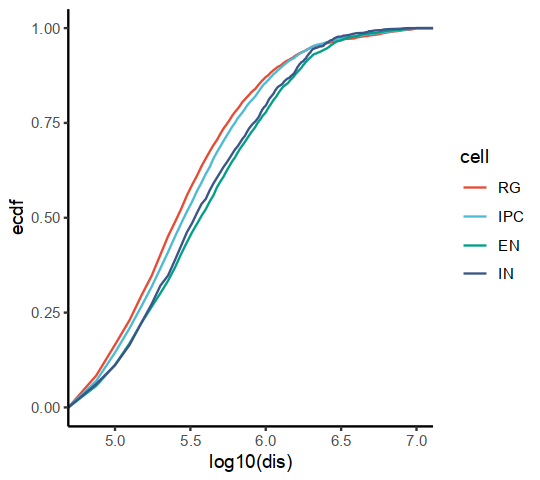

In [12]:
options(repr.plot.width=4.5,repr.plot.height=4)
ggplot(inpt, aes(log10(dis),color=cell)) + stat_ecdf(geom = "line") + 
scale_color_npg()+
theme_classic()+
xlim(4.8,7)
ggsave("../../../FINAL_figures/loop_distance_humanRG_IPC_EN_IN.pdf",height=4.5,width=4)

In [13]:
mean(RGL$dis)
mean(iPCL$dis)
mean(eNL$dis)
mean(iNL$dis)

[1] 610946.7

[1] 623088.5

[1] 754730.6

[1] 683810.1

In [14]:
#wilcox.test(RGL$dis,iPCL$dis,alternative = "less")
wilcox.test(RGL$dis,eNL$dis,alternative = "less")
#wilcox.test(RGL$dis,iNL$dis,alternative = "less")
wilcox.test(iPCL$dis,eNL$dis,alternative = "less")
#wilcox.test(iPCL$dis,iNL$dis,alternative = "less")
wilcox.test(iNL$dis,eNL$dis,alternative = "less")


	Wilcoxon rank sum test with continuity correction

data:  RGL$dis and eNL$dis
W = 27375998, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0



	Wilcoxon rank sum test with continuity correction

data:  iPCL$dis and eNL$dis
W = 22791436, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0



	Wilcoxon rank sum test with continuity correction

data:  iNL$dis and eNL$dis
W = 6993159, p-value = 0.02397
alternative hypothesis: true location shift is less than 0


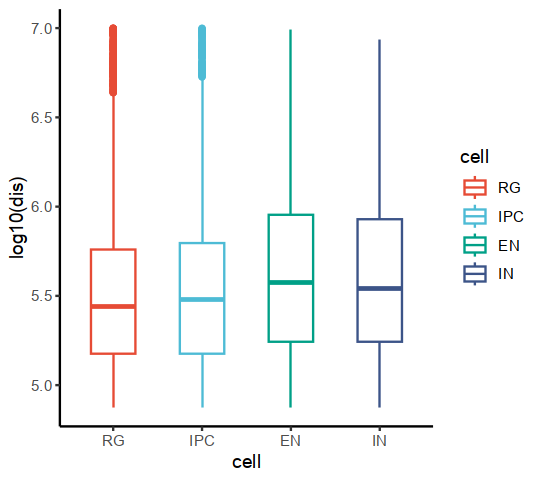

In [15]:
ggplot(data = inpt,
       aes(x = cell, y = log10(dis), color = cell)) +
  #geom_violin()+
  geom_boxplot(width=0.5,outlier.size = 1,
               position = position_dodge(.6))+
  scale_color_npg()+
  #ggpubr::s
#coord_cartesian(ylim = c(4.8,6.5))+
#geom_jitter(size=.05)+
  theme_classic()
ggsave("../../../FINAL_figures/humanBrain_fithicLoops.distance_boxplot.pdf",width=3.5,height=3)

# SIO

In [16]:
RGL <- read.table("../../../cleanData/Fithic-loops/RG_intraOnly.spline_pass1.res25000.significances.bedpe.rmBLackList.larger50Kb-smaller10Mb.C3.Q0.00001.bedpe")
eNL <- read.table("../../../cleanData/Fithic-loops/eN_intraOnly.spline_pass1.res25000.significances.bedpe.rmBLackList.larger50Kb-smaller10Mb.C3.Q0.00001.bedpe")
iPCL <- read.table("../../../cleanData/Fithic-loops/IPC_intraOnly.spline_pass1.res25000.significances.Q0.00001.count3.50kb.10Mb.bedpe.rmBlackList.bedpe")
iNL <- read.table("../../../cleanData/Fithic-loops/iN_intraOnly.spline_pass1.res25000.significances.Q0.00001.count3.50kb.10Mb.bedpe.rmBlackList.bedpe")

In [17]:
colnames(RGL) <- c("c1","s1","e1","c2","s2","e2","counts","q")
colnames(eNL) <- c("c1","s1","e1","c2","s2","e2","counts","q")
colnames(iPCL) <- c("c1","s1","e1","c2","s2","e2","counts","q")
colnames(iNL) <- c("c1","s1","e1","c2","s2","e2","counts","q")

In [18]:
RGL <- RGL%>%
filter(!(c1=="chr15"&s1==20550000)) %>% filter(!(c2=="chr15"&s2==20550000))%>%
mutate(ID1=paste(c1,s1,e1,sep="-"),ID2=paste(c2,s2,e2,sep="-"))
eNL <- eNL%>%
filter(!(c1=="chr15"&s1==20550000)) %>% filter(!(c2=="chr15"&s2==20550000))%>%
mutate(ID1=paste(c1,s1,e1,sep="-"),ID2=paste(c2,s2,e2,sep="-"))
iPCL <- iPCL%>%
filter(!(c1=="chr15"&s1==20550000)) %>% filter(!(c2=="chr15"&s2==20550000))%>%
mutate(ID1=paste(c1,s1,e1,sep="-"),ID2=paste(c2,s2,e2,sep="-"))
iNL <- iNL%>%
filter(!(c1=="chr15"&s1==20550000)) %>% filter(!(c2=="chr15"&s2==20550000))%>%
mutate(ID1=paste(c1,s1,e1,sep="-"),ID2=paste(c2,s2,e2,sep="-"))

In [19]:
RG.io <- rbind(RGL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c2,-s2,-e2,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ"),
      RGL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c1,-s1,-e1,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ")) %>%
group_by(c,s,e) %>% 
summarise(sumC=sum(counts),
          sumFDR=sum(logQ),
          N=n()) %>% 
arrange(sumFDR) 
RG.io$rank <- 1:dim(RG.io)[1]

`summarise()` has grouped output by 'c', 's'. You can override using the `.groups` argument.


In [20]:
iPC.io <- rbind(iPCL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c2,-s2,-e2,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ"),
      iPCL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c1,-s1,-e1,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ")) %>%
group_by(c,s,e) %>% 
summarise(sumC=sum(counts),
          sumFDR=sum(logQ),
          N=n()) %>% 
arrange(sumFDR) 
iPC.io$rank <- 1:dim(iPC.io)[1]

`summarise()` has grouped output by 'c', 's'. You can override using the `.groups` argument.


In [21]:
eN.io <- rbind(eNL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c2,-s2,-e2,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ"),
      eNL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c1,-s1,-e1,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ")) %>%
group_by(c,s,e) %>% 
summarise(sumC=sum(counts),
          sumFDR=sum(logQ),
          N=n()) %>% 
arrange(sumFDR) 
eN.io$rank <- 1:dim(eN.io)[1]

`summarise()` has grouped output by 'c', 's'. You can override using the `.groups` argument.


In [22]:
iN.io <- rbind(iNL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c2,-s2,-e2,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ"),
      iNL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c1,-s1,-e1,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ")) %>%
group_by(c,s,e) %>% 
summarise(sumC=sum(counts),
          sumFDR=sum(logQ),
          N=n()) %>% 
arrange(sumFDR) 
iN.io$rank <- 1:dim(iN.io)[1]

`summarise()` has grouped output by 'c', 's'. You can override using the `.groups` argument.


In [23]:
quantile(RG.io$sumFDR,c(.3,.8))
quantile(iPC.io$sumFDR,c(.3,.8))
quantile(eN.io$sumFDR,c(.3,.8))
quantile(iN.io$sumFDR,c(.3,.8))

30%       80% 
 6.463949 21.622799

30%       80% 
 6.312672 20.296534

30%       80% 
 6.186934 17.586940

30%       80% 
 5.937278 13.861588

$absolute
[1] 33.59488

$overMedian
[1] 3.666637

$overMean
[1] 2.146069

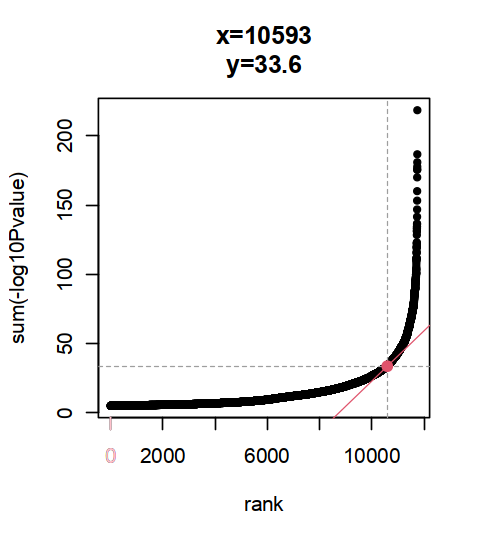

$absolute
[1] 39.72297

$overMedian
[1] 4.651994

$overMean
[1] 2.588436

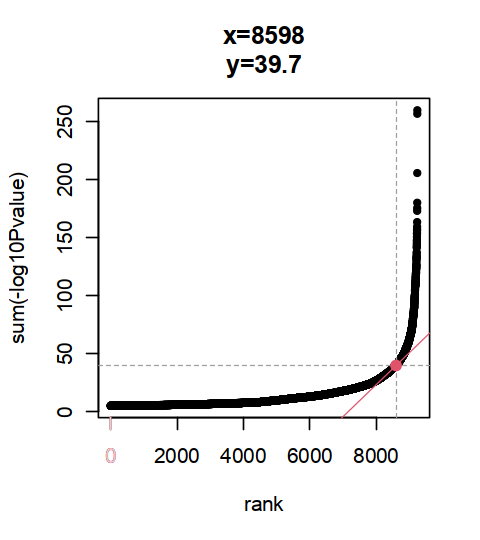

$absolute
[1] 37.80234

$overMedian
[1] 4.732289

$overMean
[1] 2.777312

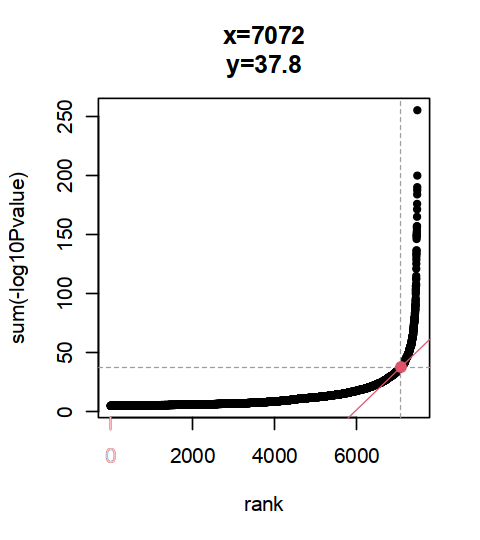

$absolute
[1] 20.6703

$overMedian
[1] 2.902581

$overMean
[1] 1.888975

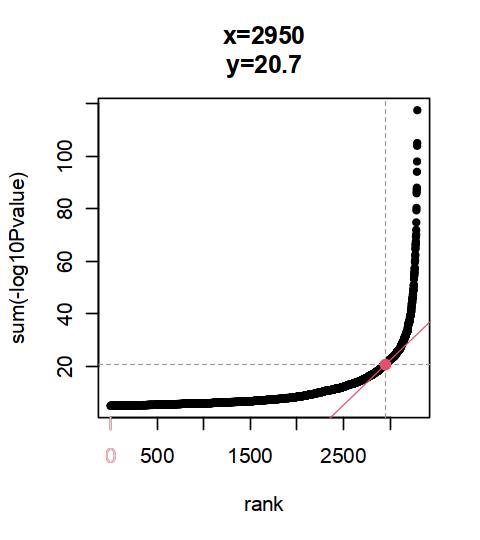

In [82]:
options(repr.plot.width=4,repr.plot.height=4.5)
calculate_cutoff(RG.io$sumFDR)
calculate_cutoff(iPC.io$sumFDR)
calculate_cutoff(eN.io$sumFDR)
calculate_cutoff(iN.io$sumFDR)

In [24]:
RG.io <- RG.io %>% 
mutate(type=case_when(sumFDR<=6.46394949915162 ~ "WIO",
                      sumFDR>= 33.5948790653437 ~ "SIO",
                      sumFDR< 33.5948790653437 && sumFDR> 6.46394949915162  ~ "IO")) 

iPC.io <- iPC.io %>% 
mutate(type=case_when(sumFDR<=8.53891360317229 ~ "WIO",
                      sumFDR>= 39.7229720637205 ~ "SIO",
                      sumFDR< 39.7229720637205 && sumFDR> 8.53891360317229  ~ "IO")) 

eN.io <- eN.io %>% 
mutate(type=case_when(sumFDR<=7.98817249552257 ~ "WIO",
                      sumFDR>= 37.8023413674133 ~ "SIO",
                      sumFDR< 37.8023413674133 && sumFDR> 7.98817249552257 ~ "IO")) 

iN.io <- iN.io %>% 
mutate(type=case_when(sumFDR<=7.12135215776694 ~ "WIO",
                      sumFDR>= 20.6703027945506 ~ "SIO",
                      sumFDR< 20.6703027945506 && sumFDR> 7.12135215776694 ~ "IO")) 

In [25]:
all.SIO2WIO <- dplyr::full_join(RG.io[,c(1:3,5)],iPC.io[,c(1:3,5)],by=c("c","s","e")) %>%
dplyr::full_join(eN.io[,c(1:3,5)],by=c("c","s","e"))%>%
#dplyr::full_join(iN.io[,c(1:3,5)],by=c("c","s","e")) %>%
replace(is.na(.),0) 
#filter(type.x=="SIO" | type.y=="SIO" | type.x.x=="SIO" | type.y.y=="SIO") %>%
#replace_na(list(sumFDR.x=0,type.x="WIO",
#                sumFDR.y=0,type.y="WIO",
#                sumFDR.x.x=0,type.x.x="WIO",
#                sumFDR.y.y=0,type.y.y="WIO")) %>%
#filter(type.x!="IO",type.y!="IO",type.x.x!="IO",type.y.y!="IO") %>%
#mutate(class=paste(type.x,type.y,type.x.x,type.y.y,sep="-"))

In [26]:
write.table(all.SIO2WIO,"./RGiPCeN_allsumSCORE.bed",col.names = F,row.names = F,quote=F,sep="\t")

In [27]:
all.SIO2WIO$rowSum <- rowSums(all.SIO2WIO[,4:6])

In [28]:
G1 <- all.SIO2WIO %>% 
         as.data.frame() %>%
arrange(desc(sumFDR.x))%>% filter(sumFDR.y <= 10,sumFDR <= 10,sumFDR.x>=20)

In [29]:
G2 <- all.SIO2WIO %>% 
         as.data.frame() %>%
arrange(desc(sumFDR.y))%>% filter(sumFDR.x <= 10,sumFDR <= 10,sumFDR.y>=20)

In [30]:
G3 <- all.SIO2WIO %>% 
         as.data.frame() %>%
arrange(desc(sumFDR))%>% filter(sumFDR.x <= 10,sumFDR.y <= 10,sumFDR>=20)

In [31]:
G4 <- all.SIO2WIO %>% 
         as.data.frame() %>%
filter(sumFDR.x > 20,sumFDR.y > 20,sumFDR>20)

In [32]:
G5 <- all.SIO2WIO %>% 
         as.data.frame() %>%
filter(sumFDR.x > 20,sumFDR.y > 20,sumFDR<=10)

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


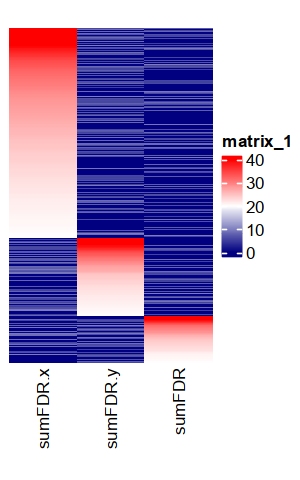

In [33]:
options(repr.plot.width=2.5,repr.plot.height=4)
pheatmap(rbind(G1,G2,G3) %>% 
         dplyr::select(sumFDR.x,sumFDR.y,sumFDR),
         breaks=c(0,40),cluster_cols = F,cluster_rows = F,cellheight = .2,
         col=colorRampPalette(c("navy","white","red1"))(500)
         )

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


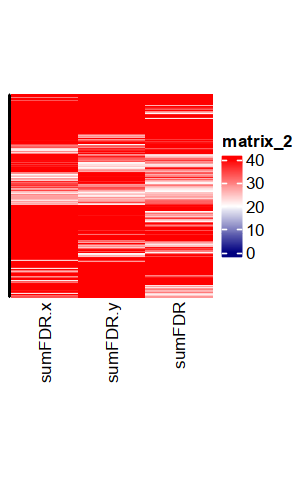

In [92]:
pheatmap(G4 %>% 
         dplyr::select(sumFDR.x,sumFDR.y,sumFDR),
         breaks=c(0,40),cluster_cols = F,cluster_rows = T,
         clustering_method = "ward.D",
         treeheight_row = 0,cellheight = .2,
         col=colorRampPalette(c("navy","white","red1"))(500))

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


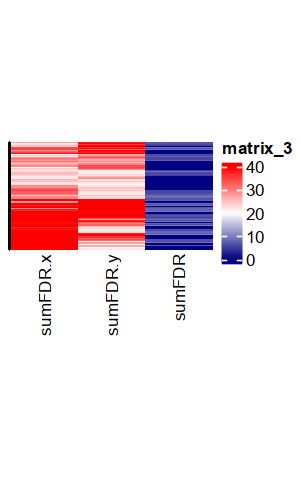

In [93]:
pheatmap(G5 %>% 
         dplyr::select(sumFDR.x,sumFDR.y,sumFDR),
         breaks=c(0,40),cluster_cols = F,cluster_rows = T,
         clustering_method = "ward.D2",
         treeheight_row = 0,cellheight = .2,
         col=colorRampPalette(c("navy","white","red1"))(500))

In [94]:
allGroup <- rbind(G1 %>% mutate(G="G1"),
G2 %>% mutate(G="G2"),
G3 %>% mutate(G="G3"),
G4 %>% mutate(G="G4"),
G5 %>% mutate(G="G5"))

In [ ]:
write.table(allGroup,"./RGiPCeN_allGroup_IO.bed",col.names = F,row.names = F,quote=F,sep="\t")

# addGene

In [34]:
RG.gene <- read.table("./RG.final.res")
iPC.gene <- read.table("./iPC.final.res")
eN.gene <- read.table("./eN.final.res")

In [35]:
G1.gene <- dplyr::left_join(G1,RG.gene,by=c("c"="V1","s"="V2","e"="V3")) %>%
select(c,s,e,sumFDR.x,sumFDR.y,sumFDR,V8) %>% distinct() 
G2.gene <- dplyr::left_join(G2,iPC.gene,by=c("c"="V1","s"="V2","e"="V3")) %>%
select(c,s,e,sumFDR.x,sumFDR.y,sumFDR,V8) %>% distinct() 
G3.gene <- dplyr::left_join(G3,eN.gene,by=c("c"="V1","s"="V2","e"="V3")) %>%
select(c,s,e,sumFDR.x,sumFDR.y,sumFDR,V8) %>% distinct() 

In [36]:
G4.gene <- dplyr::left_join(G1,rbind(RG.gene,iPC.gene),by=c("c"="V1","s"="V2","e"="V3")) %>%
select(c,s,e,sumFDR.x,sumFDR.y,sumFDR,V8) %>% distinct() 

In [37]:
G5.gene <- dplyr::left_join(G1,rbind(RG.gene,iPC.gene),by=c("c"="V1","s"="V2","e"="V3")) %>%
select(c,s,e,sumFDR.x,sumFDR.y,sumFDR,V8) %>% distinct() 

In [38]:
RNA <- read.table("../sc_human_average_CPM.txt") %>% filter(RG>0.5 | IPC >0.5 | eN >0.5 | iN >0.5)
RNA$symbol <- rownames(RNA)

In [39]:
G1.RNA <- dplyr::inner_join(G1.gene,RNA,by=c("V8"="symbol")) %>% select(-iN) %>%
mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1)) %>% 
mutate(mean=(logRG+logIPC+logeN)/3,RG=logRG-mean,IPC=logIPC-mean,eN=logeN-mean)
G2.RNA <- dplyr::inner_join(G2.gene,RNA,by=c("V8"="symbol")) %>% select(-iN) %>%
mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1)) %>% 
mutate(mean=(logRG+logIPC+logeN)/3,RG=logRG-mean,IPC=logIPC-mean,eN=logeN-mean)
G3.RNA <- dplyr::inner_join(G3.gene,RNA,by=c("V8"="symbol")) %>% select(-iN) %>%
mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1)) %>% 
mutate(mean=(logRG+logIPC+logeN)/3,RG=logRG-mean,IPC=logIPC-mean,eN=logeN-mean)
G4.RNA <- dplyr::inner_join(G4.gene,RNA,by=c("V8"="symbol")) %>% select(-iN) %>%
mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1)) %>% 
mutate(mean=(logRG+logIPC+logeN)/3,RG=logRG-mean,IPC=logIPC-mean,eN=logeN-mean)
G5.RNA <- dplyr::inner_join(G5.gene,RNA,by=c("V8"="symbol")) %>% select(-iN) %>%
mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1)) %>% 
mutate(mean=(logRG+logIPC+logeN)/3,RG=logRG-mean,IPC=logIPC-mean,eN=logeN-mean)

In [390]:
G1.RNA.adjust <- G1.RNA %>% filter(!V8 %in% G3.RNA$V8) %>%
filter(!V8 %in% G2.RNA$V8)
G2.RNA.adjust <- G2.RNA %>% filter(!V8 %in% G1.RNA$V8) %>%
filter(!V8 %in% G3.RNA$V8)
G3.RNA.adjust <- G3.RNA %>% filter(!V8 %in% G1.RNA$V8) %>%
filter(!V8 %in% G2.RNA$V8)

In [391]:
markPE <- read.table("./RGiPCeN_allGroup_IO.bed.PromoterOrEnhancer") %>%
mutate(CRE=case_when(V5=="."  ~ "distal",
                     V5!="."  ~ "promoter"),
      CRE.all=paste0(CRE,"-",V5)) %>% 
select(V1,V2,V3,CRE,CRE.all) %>% distinct()

In [392]:
G1.RNA.adjust <- dplyr::left_join(G1.RNA.adjust,markPE,by=c("c"="V1","s"="V2","e"="V3"))
G1.RNA.adjust.ID <- G1.RNA.adjust %>% select(c,s,e) %>% distinct() %>% mutate(ID=1:565)

Warning message in dplyr::left_join(G1.RNA.adjust, markPE, by = c(c = "V1", s = "V2", :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


In [393]:
G3.RNA.adjust <- dplyr::left_join(G3.RNA.adjust,markPE,by=c("c"="V1","s"="V2","e"="V3")) 
G3.RNA.adjust.ID <- G3.RNA.adjust %>% select(c,s,e) %>% distinct() %>% mutate(ID=1:111)

Warning message in dplyr::left_join(G3.RNA.adjust, markPE, by = c(c = "V1", s = "V2", :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 20 of `x` matches multiple rows in `y`.
ℹ Row 1019 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


In [394]:
G2.RNA.adjust <- dplyr::left_join(G2.RNA.adjust,markPE,by=c("c"="V1","s"="V2","e"="V3")) 
G2.RNA.adjust.ID <- G2.RNA.adjust %>% select(c,s,e) %>% distinct() %>% mutate(ID=1:168)

Warning message in dplyr::left_join(G2.RNA.adjust, markPE, by = c(c = "V1", s = "V2", :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 35 of `x` matches multiple rows in `y`.
ℹ Row 764 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


In [402]:
G3.sta <- G3.RNA.adjust %>% dplyr::left_join(.,G3.RNA.adjust.ID,by=c("c","s","e")) %>% 
select(V8,ID,CRE,CRE.all) %>% distinct() %>% group_by(V8,CRE) %>% 
summarise(N=n()) %>%
tidyr::pivot_wider(id_cols = c("V8"), names_from = "CRE", values_from = "N")  %>%
replace(is.na(.),0)%>% as.data.frame()

`summarise()` has grouped output by 'V8'. You can override using the `.groups` argument.


In [403]:
G1.sta <- G1.RNA.adjust %>% dplyr::left_join(.,G1.RNA.adjust.ID,by=c("c","s","e")) %>% 
select(V8,ID,CRE,CRE.all) %>% distinct() %>% group_by(V8,CRE) %>% 
summarise(N=n()) %>%
tidyr::pivot_wider(id_cols = c("V8"), names_from = "CRE", values_from = "N")  %>%
replace(is.na(.),0)%>% as.data.frame()

`summarise()` has grouped output by 'V8'. You can override using the `.groups` argument.


In [453]:
G2.sta <- G2.RNA.adjust %>% dplyr::left_join(.,G2.RNA.adjust.ID,by=c("c","s","e")) %>% 
select(V8,ID,CRE,CRE.all) %>% distinct() %>% group_by(V8,CRE) %>% 
summarise(N=n()) %>%
tidyr::pivot_wider(id_cols = c("V8"), names_from = "CRE", values_from = "N")  %>%
replace(is.na(.),0)%>% as.data.frame()

`summarise()` has grouped output by 'V8'. You can override using the `.groups` argument.


In [405]:
G3.sta.plotDF <- rbind(G3.sta[,1:2] %>% set_names("symbol","counts") %>% mutate(group="distal"),
G3.sta[,c(1,3)] %>% set_names("symbol","counts") %>% mutate(group="promoter")) %>% as.data.frame()

In [406]:
G1.sta.plotDF <- rbind(G1.sta[,1:2] %>% set_names("symbol","counts") %>% mutate(group="distal"),
G1.sta[,c(1,3)] %>% set_names("symbol","counts") %>% mutate(group="promoter")) %>% as.data.frame()

In [451]:
G2.sta.plotDF <- rbind(G2.sta[,1:2] %>% set_names("symbol","counts") %>% mutate(group="distal"),
G2.sta[,c(1,3)] %>% set_names("symbol","counts") %>% mutate(group="promoter")) %>% as.data.frame()

In [460]:
G3.mat <- matrix(0,ncol = 5,nrow = 5) %>% as.data.frame()
G1.mat <- matrix(0,ncol = 9,nrow = 9) %>% as.data.frame()
G2.mat <- matrix(0,ncol = 9,nrow = 9) %>% as.data.frame()

In [461]:
for(i in 1:dim(G3.sta)[1]){
   r=G3.sta[i,3]+1
   c=G3.sta[i,2]+1
   #print(r)
   #print(c)
   G3.mat[r,c] <- G3.mat[r,c]+1
   #G3.mat[c,r] <- G3.mat[c,r]+1      
}
for(i in 1:dim(G1.sta)[1]){
   r=G1.sta[i,3]+1
   c=G1.sta[i,2]+1
   #print(r)
   #print(c)
   G1.mat[r,c] <- G1.mat[r,c]+1
   #G3.mat[c,r] <- G3.mat[c,r]+1      
}
for(i in 1:dim(G2.sta)[1]){
   c=G2.sta[i,3]+1
   r=G2.sta[i,2]+1
   #print(r)
   #print(c)
   G2.mat[r,c] <- G2.mat[r,c]+1
   #G3.mat[c,r] <- G3.mat[c,r]+1      
}

In [473]:
G2.sta %>% filter(distal==0,promoter==7)

V8,promoter,distal
<chr>,<int>,<int>
DALRD3,7,0
IMPDH2,7,0
NDUFAF3,7,0
SLC26A6,7,0


Warning message:
“The input is a data frame, convert it to the matrix.”


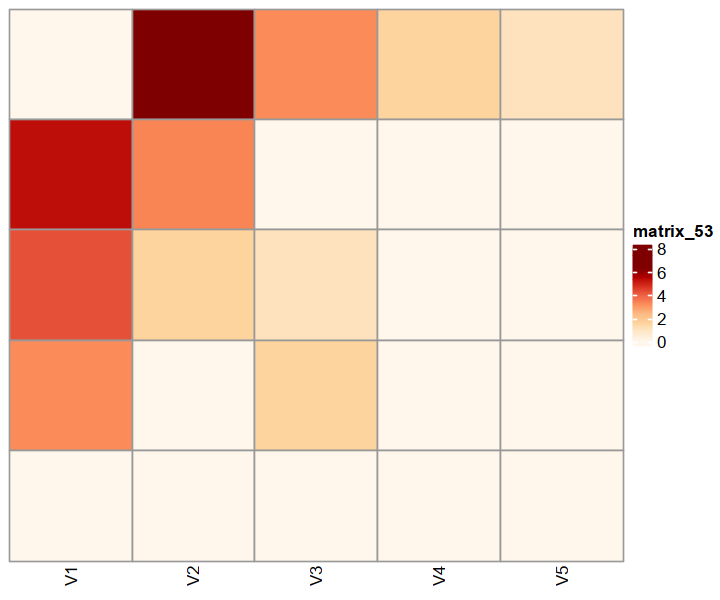

In [475]:
pheatmap(log2(G3.mat+1),cluster_rows = F,cluster_cols = F,display_numbers = F,
         color = coul)

Warning message:
“The input is a data frame, convert it to the matrix.”


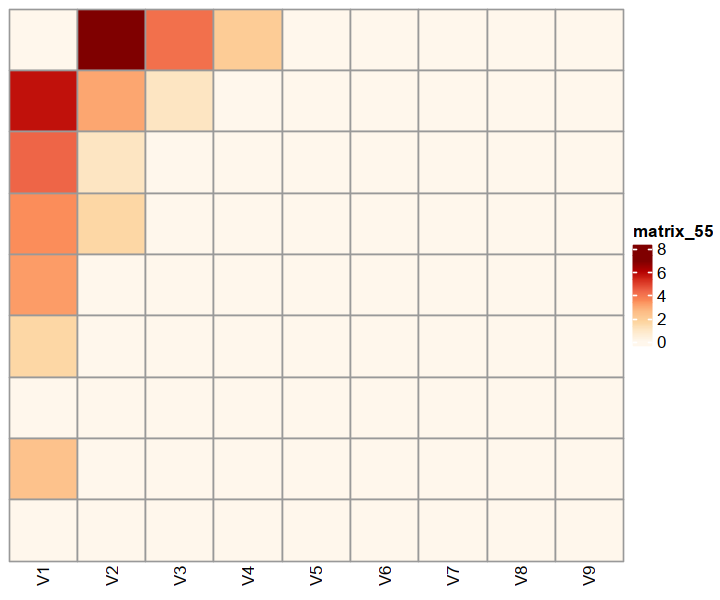

In [477]:
pheatmap(log2(G2.mat+1),cluster_rows = F,cluster_cols = F,display_numbers = F,
         color = coul)

In [469]:
coul <- colorRampPalette(brewer.pal(9, "OrRd"))(50)
pdf("../../../FINAL_figures/SIO_group_in_human.eN.pdf",width=5,height=4.5)
pheatmap(log2(G3.mat+1),cluster_rows = F,cluster_cols = F,display_numbers = F,
         color = coul)
dev.off()
pdf("../../../FINAL_figures/SIO_group_in_human.RG.pdf",width=5,height=4.5)
pheatmap(log2(G1.mat+1),cluster_rows = F,cluster_cols = F,display_numbers = F,
         color = coul)
dev.off()
pdf("../../../FINAL_figures/SIO_group_in_human.iPC.pdf",width=5,height=4.5)
pheatmap(log2(G2.mat+1),cluster_rows = F,cluster_cols = F,display_numbers = F,
         color = coul)
dev.off()

Warning message:
“The input is a data frame, convert it to the matrix.”


png 
  2

Warning message:
“The input is a data frame, convert it to the matrix.”


png 
  2

Warning message:
“The input is a data frame, convert it to the matrix.”


png 
  2

In [167]:
RGSIP.gene <- read.table("/lustre/user/liclab/jialm/Project/SCOPEC/analysis/SIP/RG_SIPand5kinbin_gene.filtered.uniq")
ENSIP.gene <- read.table("/lustre/user/liclab/jialm/Project/SCOPEC/analysis/SIP/EN_SIPand5kinbin_gene.filtered.uniq")

In [178]:
sip.rg.spec <- setdiff(RGSIP.gene$V1,ENSIP.gene$V1) %>% as.data.frame() %>% set_names("symbol")
sip.en.spec <- setdiff(ENSIP.gene$V1,RGSIP.gene$V1) %>% as.data.frame() %>% set_names("symbol")

In [181]:
sip.en.spec.RNAadj <- dplyr::inner_join(sip.en.spec,RNA)
sip.rg.spec.RNAadj <- dplyr::inner_join(sip.rg.spec,RNA)

Joining with `by = join_by(symbol)`
Joining with `by = join_by(symbol)`


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


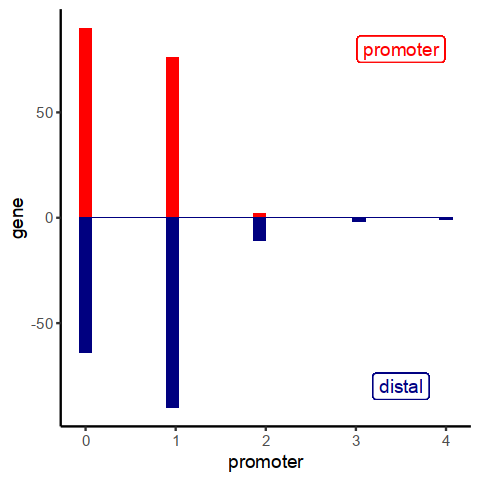

In [113]:
options(repr.plot.width=4,repr.plot.height=4)
ggplot(G3.sta) +
  geom_histogram(aes(promoter,y = after_stat(count)),fill="red")+
  geom_label(aes(x=3.5, y=80, label="promoter"), color="red") +
  geom_histogram(aes(distal,y = -after_stat(count)),fill="navy")+
  geom_label(aes(x=3.5, y=-80, label="distal"), color="navy") +
ylab("gene")+
theme_classic()

In [102]:
library(ComplexHeatmap)

In [241]:
G1.ha <- rowAnnotation(
  foo = anno_mark(
    at = G1.RNA.adjust %>% mutate(rank=1:dim(G1.RNA.adjust)[1]) %>% 
filter(RG>=2.5,IPC<=-0.5,eN<=-0.5) %>%
filter(!grepl("-AS1",.$V8))%>% .$rank, 
    labels = G1.RNA.adjust %>% mutate(rank=1:dim(G1.RNA.adjust)[1]) %>% 
filter(RG>=2.5,IPC<=-0.5,eN<=-0.5)%>%
filter(!grepl("-AS1",.$V8)) %>% .$V8)
  )

G2.ha <- rowAnnotation(
  foo = anno_mark(
    at = G2.RNA.adjust %>% mutate(rank=1:dim(G2.RNA.adjust)[1]) %>% 
filter(IPC>=2.4,eN<=1,RG<=1)%>%
filter(!grepl("-AS1",.$V8))%>% .$rank, 
    labels = G2.RNA.adjust %>% mutate(rank=1:dim(G2.RNA.adjust)[1]) %>% 
filter(IPC>=2.4,eN<=1,RG<=1)%>%
filter(!grepl("-AS1",.$V8))%>% .$V8)
  )

G3.ha <- rowAnnotation(
  foo = anno_mark(
    at = G3.RNA.adjust %>% mutate(rank=1:dim(G3.RNA.adjust)[1]) %>% 
filter(eN>=2.4,IPC<=1,RG<=1)%>%
filter(!grepl("-AS1",.$V8),logeN>=9)%>% .$rank, 
    labels = G3.RNA.adjust %>% mutate(rank=1:dim(G3.RNA.adjust)[1]) %>% 
filter(eN>=2.4,IPC<=1,RG<=1)%>%
filter(!grepl("-AS1",.$V8),logeN>=9)%>% .$V8)
  )

In [242]:
ann_colors=list(CRE=c(distal="black",promoter="lightgray")) 

In [243]:
markPE %>% distinct() %>% group_by(CRE) %>% summarise(N=n())

CRE,N
<chr>,<int>
distal,1162
promoter,775


In [244]:
G123_genePromoter <- rbind(G1.RNA.adjust,G2.RNA.adjust,G3.RNA.adjust) %>% 
mutate(ID=1:1903) %>% 
select(V8,ID) %>% 
dplyr::left_join(.,promoter,by=c("V8"="symbol")) 

In [245]:
G123_genePromoter.gr <- rbind(G1.RNA.adjust,G2.RNA.adjust,G3.RNA.adjust) %>% 
mutate(ID=1:1903) %>% 
select(V8,ID) %>% 
dplyr::left_join(.,promoter,by=c("V8"="symbol")) %>% makeGRangesFromDataFrame(.,keep.extra.columns = T)

In [246]:
RGpeak <- read.table("./RG.all.merge.DEPairs.AB.merge.rmd.DEPairs.bed.macs2.ext200.shift100.0.01_peaks.narrowPeak") %>% select(V1,V2,V3,V9) %>% set_names("seqnames","start","end","FDR") %>%
mutate(FDR=FDR/sum(FDR)*9000000)
IPCpeak <- read.table("./iPC.all.merge.DEPairs.AB.merge.rmd.DEPairs.bed.macs2.ext200.shift100.0.01_peaks.narrowPeak") %>% select(V1,V2,V3,V9) %>% set_names("seqnames","start","end","FDR") %>%
mutate(FDR=FDR/sum(FDR)*11000000)
ENpeak <- read.table("./eN.all.merge.DEPairs.AB.merge.rmd.DEPairs.bed.macs2.ext200.shift100.0.01_peaks.narrowPeak") %>% select(V1,V2,V3,V9) %>% set_names("seqnames","start","end","FDR") %>%
mutate(FDR=FDR/sum(FDR)*10000000)
RGATAC <- read.table("../RG_eN/RG.ATAC-seq.38TO19.narrowPeak")%>% select(V1,V2,V3,V9) %>% set_names("seqnames","start","end","FDR") %>%
mutate(FDR=FDR/sum(FDR)*10000000)
IPCATAC <- read.table("../RG_eN/IPC.ATAC-seq.38TO19.narrowPeak")%>% select(V1,V2,V3,V9) %>% set_names("seqnames","start","end","FDR") %>%
mutate(FDR=FDR/sum(FDR)*11000000)
ENATAC <- read.table("../RG_eN/eN.ATAC-seq.38TO19.narrowPeak")%>% select(V1,V2,V3,V9) %>% set_names("seqnames","start","end","FDR") %>%
mutate(FDR=FDR/sum(FDR)*10000000)
RGpeak.gr <- makeGRangesFromDataFrame(RGpeak,keep.extra.columns = T)
IPCpeak.gr <- makeGRangesFromDataFrame(IPCpeak,keep.extra.columns = T)
ENpeak.gr <- makeGRangesFromDataFrame(ENpeak,keep.extra.columns = T)
RGATAC.gr <- makeGRangesFromDataFrame(RGATAC,keep.extra.columns = T)
IPCATAC.gr <- makeGRangesFromDataFrame(IPCATAC,keep.extra.columns = T)
ENATAC.gr <- makeGRangesFromDataFrame(ENATAC,keep.extra.columns = T)

In [247]:
RGC <- cbind(G123_genePromoter[queryHits(findOverlaps(G123_genePromoter.gr,RGpeak.gr,select = "all")),],
RGpeak[subjectHits(findOverlaps(G123_genePromoter.gr,RGpeak.gr,select = "all")),]) %>% set_names("symbol","ID","seqnames","start","end","chromsome","peak.start","peak.end","FDR") %>% 
group_by(symbol,ID) %>% summarise(FDR=sum(FDR)) %>% arrange(ID) %>% as.data.frame()

IPCC <- cbind(G123_genePromoter[queryHits(findOverlaps(G123_genePromoter.gr,IPCpeak.gr,select = "all")),],
IPCpeak[subjectHits(findOverlaps(G123_genePromoter.gr,IPCpeak.gr,select = "all")),]) %>% set_names("symbol","ID","seqnames","start","end","chromsome","peak.start","peak.end","FDR") %>% 
group_by(symbol,ID) %>% summarise(FDR=sum(FDR)) %>% arrange(ID) %>% as.data.frame()

ENC <- cbind(G123_genePromoter[queryHits(findOverlaps(G123_genePromoter.gr,ENpeak.gr,select = "all")),],
ENpeak[subjectHits(findOverlaps(G123_genePromoter.gr,ENpeak.gr,select = "all")),]) %>% set_names("symbol","ID","seqnames","start","end","chromsome","peak.start","peak.end","FDR") %>% 
group_by(symbol,ID) %>% summarise(FDR=sum(FDR)) %>% arrange(ID) %>% as.data.frame()

`summarise()` has grouped output by 'symbol'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'symbol'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'symbol'. You can override using the `.groups` argument.


In [248]:
RGA <- cbind(G123_genePromoter[queryHits(findOverlaps(G123_genePromoter.gr,RGATAC.gr,select = "all")),],
RGATAC[subjectHits(findOverlaps(G123_genePromoter.gr,RGATAC.gr,select = "all")),]) %>% set_names("symbol","ID","seqnames","start","end","chromsome","peak.start","peak.end","FDR") %>% 
group_by(symbol,ID) %>% summarise(FDR=sum(FDR)) %>% arrange(ID) %>% as.data.frame()

IPCA <- cbind(G123_genePromoter[queryHits(findOverlaps(G123_genePromoter.gr,IPCATAC.gr,select = "all")),],
IPCATAC[subjectHits(findOverlaps(G123_genePromoter.gr,IPCATAC.gr,select = "all")),]) %>% set_names("symbol","ID","seqnames","start","end","chromsome","peak.start","peak.end","FDR") %>% 
group_by(symbol,ID) %>% summarise(FDR=sum(FDR)) %>% arrange(ID) %>% as.data.frame()

ENA <- cbind(G123_genePromoter[queryHits(findOverlaps(G123_genePromoter.gr,ENATAC.gr,select = "all")),],
ENATAC[subjectHits(findOverlaps(G123_genePromoter.gr,ENATAC.gr,select = "all")),]) %>% set_names("symbol","ID","seqnames","start","end","chromsome","peak.start","peak.end","FDR") %>% 
group_by(symbol,ID) %>% summarise(FDR=sum(FDR)) %>% arrange(ID) %>% as.data.frame()

`summarise()` has grouped output by 'symbol'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'symbol'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'symbol'. You can override using the `.groups` argument.


In [249]:
res <- dplyr::left_join(G123_genePromoter[,1:2],RGC,by=c("V8"="symbol","ID"="ID")) %>%
dplyr::left_join(.,IPCC,by=c("V8"="symbol","ID"="ID")) %>%
dplyr::left_join(.,ENC,by=c("V8"="symbol","ID"="ID")) %>%
dplyr::left_join(.,RGA,by=c("V8"="symbol","ID"="ID")) %>%
dplyr::left_join(.,IPCA,by=c("V8"="symbol","ID"="ID")) %>%
dplyr::left_join(.,ENA,by=c("V8"="symbol","ID"="ID")) %>%
replace(is.na(.),100) %>% 
set_names("symbol","ID","RG.SC","IPC.SC","EN.SC","RG.ATAC","IPC.ATAC","EN.ATAC")

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


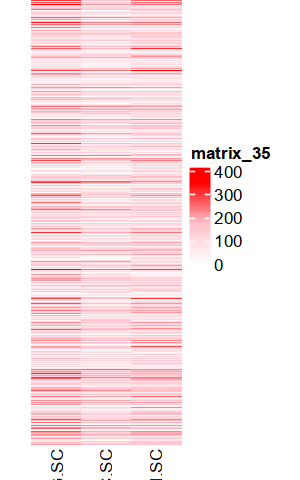

In [250]:
options(repr.plot.width=2.5,repr.plot.height=4)
#pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG123_SCOPEC1D.pdf",width=5,height=8)
pheatmap(res[,c(3:5)],breaks=c(0,350),
         #right_annotation = G1.ha,
         cluster_cols = F,cluster_rows = F,cellheight = .15,cellwidth = 30,
         col=colorRampPalette(c("white","pink","red"))(500)
         )
#dev.off()

In [322]:
pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG123_ATACpeak.pdf",width=5,height=8)
pheatmap(res[,c(6:8)],breaks=c(0,1400),
         #right_annotation = G1.ha,
         cluster_cols = F,cluster_rows = F,cellheight = .15,cellwidth = 30,
         col=colorRampPalette(c("white","forestgreen","black"))(500)
         )
dev.off()

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


png 
  2

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


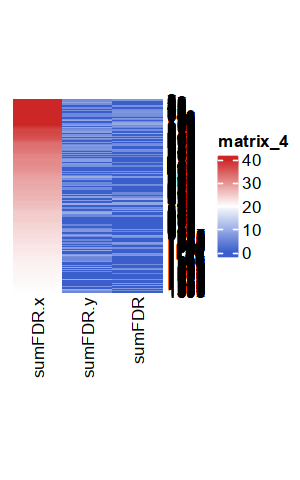

In [137]:
ComplexHeatmap::pheatmap(G1.RNA.adjust[G1.RNA.adjust$CRE=="promoter",c(4:6)],
         breaks=c(0,40),
         cluster_cols = F,cluster_rows = F,cellheight = .15,cellwidth = 30,
         col=colorRampPalette(c("royalblue3","white","firebrick3"))(500))

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


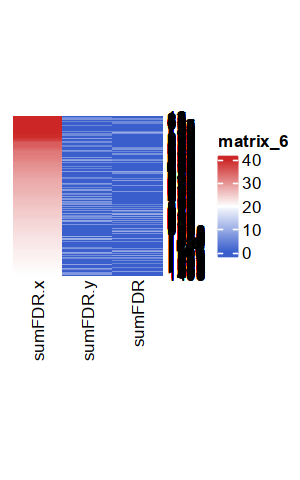

In [139]:
ComplexHeatmap::pheatmap(G1.RNA.adjust[G1.RNA.adjust$CRE=="distal",c(4:6)],
         breaks=c(0,40),
         cluster_cols = F,cluster_rows = F,cellheight = .15,cellwidth = 30,
         col=colorRampPalette(c("royalblue3","white","firebrick3"))(500))

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


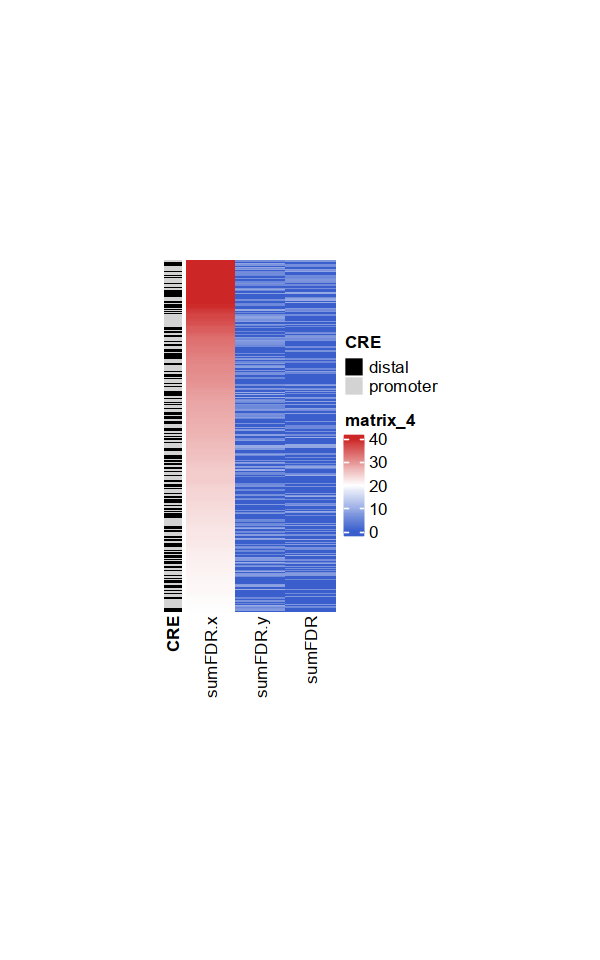

In [61]:
ComplexHeatmap::pheatmap(G1.RNA.adjust[,c(4:6)],
         breaks=c(0,40),annotation_row=dplyr::left_join(G1.RNA.adjust,markPE,by=c("c"="V1","s"="V2","e"="V3")) %>% 
                         select(CRE),annotation_colors=ann_colors,
         cluster_cols = F,cluster_rows = F,cellheight = .15,cellwidth = 30,
         col=colorRampPalette(c("royalblue3","white","firebrick3"))(500))

In [ ]:
options(repr.plot.width=2.5,repr.plot.height=4)
pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG1_RNAseq.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G1.RNA.adjust[,c(8,9,10)],
         breaks=c(-1,2),right_annotation = G1.ha,
         cluster_cols = F,cluster_rows = F,cellheight = .15,cellwidth = 30,
         col=colorRampPalette(c("white","slategray2","midnightblue"))(500)
         )
dev.off()

pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG1_interactiveScore.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G1.RNA.adjust[,c(4:6)],
         breaks=c(0,40),annotation_row=dplyr::left_join(G1.RNA.adjust,markPE,by=c("c"="V1","s"="V2","e"="V3")) %>% 
                         select(CRE),annotation_colors=ann_colors,
         cluster_cols = F,cluster_rows = F,cellheight = .15,cellwidth = 30,
         col=colorRampPalette(c("royalblue3","white","firebrick3"))(500)
         )
dev.off()

In [ ]:
pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG2_RNAseq.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G2.RNA.adjust[,c(8,9,10)],
         breaks=c(-1,2),right_annotation = G2.ha,
         cluster_cols = F,cluster_rows = F,cellheight = .3,cellwidth = 30,
         col=colorRampPalette(c("white","slategray2","midnightblue"))(500)
         )
dev.off()

pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG2_interactiveScore.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G2.RNA.adjust[,c(4:6)],
         breaks=c(0,40),annotation_row=dplyr::left_join(G2.RNA.adjust,markPE,by=c("c"="V1","s"="V2","e"="V3")) %>% 
                         select(CRE),annotation_colors=ann_colors,
         cluster_cols = F,cluster_rows = F,cellheight = .3,cellwidth = 30,
         col=colorRampPalette(c("royalblue3","white","firebrick3"))(500)
         )
dev.off()

In [ ]:
pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG3_RNAseq.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G3.RNA.adjust[,c(8,9,10)],
         breaks=c(-1,2),right_annotation = G3.ha,
         cluster_cols = F,cluster_rows = F,cellheight = .3,cellwidth = 30,
         col=colorRampPalette(c("white","slategray2","midnightblue"))(500)
         )
dev.off()

pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG3_interactiveScore.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G3.RNA.adjust[,c(4:6)],
         breaks=c(0,40),annotation_row=dplyr::left_join(G3.RNA.adjust,markPE,by=c("c"="V1","s"="V2","e"="V3")) %>% 
                         select(CRE),annotation_colors=ann_colors,
         cluster_cols = F,cluster_rows = F,cellheight = .3,cellwidth = 30,
         col=colorRampPalette(c("royalblue3","white","firebrick3"))(500)
         )
dev.off()

In [252]:
G1.RNA.adjust <- G1.RNA.adjust %>% mutate(exp="G1")
G2.RNA.adjust <- G2.RNA.adjust %>% mutate(exp="G2")
G3.RNA.adjust <- G3.RNA.adjust %>% mutate(exp="G3")

In [328]:
RNAplotDF <- rbind(G1.RNA.adjust[,c(7,11,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="RG"),
                   G1.RNA.adjust[,c(7,12,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="iPC"),
                   G1.RNA.adjust[,c(7,13,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="eN"),
                   G2.RNA.adjust[,c(7,11,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="RG"),
                   G2.RNA.adjust[,c(7,12,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="iPC"),
                   G2.RNA.adjust[,c(7,13,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="eN"),
                   G3.RNA.adjust[,c(7,11,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="RG"),
                   G3.RNA.adjust[,c(7,12,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="iPC"),
                   G3.RNA.adjust[,c(7,13,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="eN")
                   
      )

In [258]:
dim(G1.RNA.adjust)
dim(G2.RNA.adjust)
dim(G3.RNA.adjust)

[1] 1410   16

[1] 291  16

[1] 202  16

In [330]:
library(ggforce)

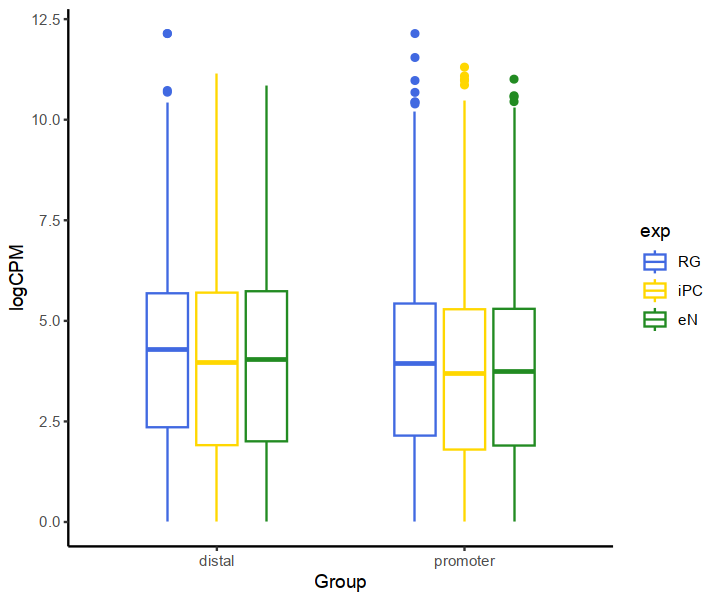

In [329]:
options(repr.plot.width=6,repr.plot.height=5)
ggplot(data = RNAplotDF %>% mutate(exp=factor(RNAplotDF$exp,levels=c("RG","iPC","eN"))),
       aes(x = Group, y = logCPM, color = exp)) +
  #geom_violin()+
  geom_boxplot(width=0.5,
               position = position_dodge(.6))+
  scale_color_manual(values = c("royalblue","gold","forestgreen"))+
#coord_cartesian(ylim = c(0,8))+
#geom_jitter(size=.1)+
#geom_sina(size=0.01,alpha=1)+
  theme_classic()

In [282]:
exp <-rbind(G1.RNA.adjust %>% filter(exp=="G1") %>% 
select(V8,logRG,logIPC,logeN) %>% distinct() %>% 
mutate(cell="RG"),
G2.RNA.adjust %>% filter(exp=="G2") %>% 
select(V8,logRG,logIPC,logeN) %>% distinct() %>% 
mutate(cell="IPC"),
G3.RNA.adjust %>% filter(exp=="G3") %>% 
select(V8,logRG,logIPC,logeN) %>% distinct() %>% 
mutate(cell="EN"))

In [288]:
exp.plotDF <- rbind(exp[,c(1,2,5)] %>% set_names("symbol","logCPM","cell")%>% mutate(RNA="RG"),
                    exp[,c(1,3,5)] %>% set_names("symbol","logCPM","cell")%>% mutate(RNA="IPC"),
                    exp[,c(1,4,5)] %>% set_names("symbol","logCPM","cell")%>% mutate(RNA="EN")
                    )

In [294]:
exp.plotDF$cell <- factor(exp.plotDF$cell,levels=c("RG","IPC","EN"))
exp.plotDF$RNA <- factor(exp.plotDF$RNA,levels=c("RG","IPC","EN"))

In [1]:
options(repr.plot.width=5,repr.plot.height=4)
ggplot(data = exp.plotDF,
       aes(x = cell, y = logCPM, color = RNA)) +
  #geom_violin()+
  geom_boxplot(width=0.5,outlier.size = 0.6,
               position = position_dodge(.6))+
  scale_color_manual(values = c("royalblue","orange","forestgreen"))+
#coord_cartesian(ylim = c(0,8))+
#geom_jitter(size=.05)+
#geom_sina(size=0.01,alpha=1)+
  theme_classic()
ggsave("../../../FINAL_figures/humanBrain_RGIPCEN_SIORelgenelogCPM.boxplot.pdf",width=5,height=4)

ERROR: Error in ggplot(data = exp.plotDF, aes(x = cell, y = logCPM, color = RNA)): 没有"ggplot"这个函数


In [315]:
wilcox.test(exp %>% filter(cell=="RG") %>% .$logRG,
            exp %>% filter(cell=="RG") %>% .$logIPC,alternative="greater")
wilcox.test(exp %>% filter(cell=="RG") %>% .$logRG,
            exp %>% filter(cell=="RG") %>% .$logeN,alternative="greater")


	Wilcoxon rank sum test with continuity correction

data:  exp %>% filter(cell == "RG") %>% .$logRG and exp %>% filter(cell == "RG") %>% .$logIPC
W = 654691, p-value = 0.0009642
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  exp %>% filter(cell == "RG") %>% .$logRG and exp %>% filter(cell == "RG") %>% .$logeN
W = 653374, p-value = 0.001294
alternative hypothesis: true location shift is greater than 0


In [316]:
wilcox.test(exp %>% filter(cell=="IPC") %>% .$logIPC,
            exp %>% filter(cell=="IPC") %>% .$logRG,alternative="greater")
wilcox.test(exp %>% filter(cell=="IPC") %>% .$logIPC,
            exp %>% filter(cell=="IPC") %>% .$logeN,alternative="greater")


	Wilcoxon rank sum test with continuity correction

data:  exp %>% filter(cell == "IPC") %>% .$logIPC and exp %>% filter(cell == "IPC") %>% .$logRG
W = 31813, p-value = 0.2532
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  exp %>% filter(cell == "IPC") %>% .$logIPC and exp %>% filter(cell == "IPC") %>% .$logeN
W = 31638, p-value = 0.2896
alternative hypothesis: true location shift is greater than 0


In [320]:
wilcox.test(exp %>% filter(cell=="EN") %>% .$logeN,
            exp %>% filter(cell=="EN") %>% .$logRG,alternative="greater")
wilcox.test(exp %>% filter(cell=="EN") %>% .$logeN,
            exp %>% filter(cell=="EN") %>% .$logIPC,alternative="greater")


	Wilcoxon rank sum test with continuity correction

data:  exp %>% filter(cell == "EN") %>% .$logeN and exp %>% filter(cell == "EN") %>% .$logRG
W = 16020, p-value = 0.01607
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  exp %>% filter(cell == "EN") %>% .$logeN and exp %>% filter(cell == "EN") %>% .$logIPC
W = 15679, p-value = 0.03924
alternative hypothesis: true location shift is greater than 0


In [324]:
wilcox.test(G1.RNA.adjust$logRG,G1.RNA.adjust$logIPC,alternative = "greater")
wilcox.test(G1.RNA.adjust$logRG,G1.RNA.adjust$logeN,alternative = "greater")


	Wilcoxon rank sum test with continuity correction

data:  G1.RNA.adjust$logRG and G1.RNA.adjust$logIPC
W = 1079803, p-value = 3.644e-05
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  G1.RNA.adjust$logRG and G1.RNA.adjust$logeN
W = 1071150, p-value = 0.000181
alternative hypothesis: true location shift is greater than 0


In [327]:
library(gprofiler2)
library(clusterProfiler)
library(enrichplot)
library(DOSE)



Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

clusterProfiler v4.2.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


载入程辑包：‘clusterProfiler’


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


DOSE v3.20.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontolog

In [ ]:
G1res <- gost(query = unique(G1.RNA.adjust$V8),
organism = "hsapiens")
G2res <- gost(query = unique(G2.RNA.adjust$V8),
organism = "hsapiens")
G3res <- gost(query = unique(G3.RNA.adjust$V8),
organism = "hsapiens")

In [ ]:
G1res$result %>% filter(source =="GO:BP") %>% 
arrange(p_value) %>%  
filter(term_size <= 5000) %>% 
select(p_value,source,term_size,term_name,intersection_size,term_id,p_value) %>%
distinct() %>% head()

In [ ]:
RNA <- RNA %>% mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1))

In [ ]:
allRG.exp.gene <- RNA %>% filter(RG>0.5) %>% .$symbol %>% unique()
RG.exp.withoutSIO <- setdiff(allRG.exp.gene,unique(G1.RNA.adjust$V8))

In [ ]:
options(repr.plot.width=6,repr.plot.height=3)
gostplot(G1res, capped = T, interactive = F)

## enrich analysis

In [ ]:
RG.sio_names = gconvert(unique(G1.RNA.adjust$V8))
IPC.sio_names = gconvert(unique(G2.RNA.adjust$V8))
eN.sio_names = gconvert(unique(G3.RNA.adjust$V8))

In [ ]:
Groups.multi_gp = gost(list("RG" = RG.sio_names$name,
                            "iPC" = IPC.sio_names$name,
                            "eN" = eN.sio_names$name), 
                       multi_query = FALSE, evcodes = TRUE)

In [ ]:
# modify the g:Profiler data frame
gp_mod =Groups.multi_gp$result[,c("query", "source", "term_id",
                                "term_name", "p_value", "query_size", 
                                "intersection_size", "term_size", 
                                "effective_domain_size", "intersection")]
gp_mod$GeneRatio = paste0(gp_mod$intersection_size,  "/", gp_mod$query_size)
gp_mod$BgRatio = paste0(gp_mod$term_size, "/", gp_mod$effective_domain_size)
names(gp_mod) = c("Cluster", "Category", "ID", "Description", "p.adjust", 
                    "query_size", "Count", "term_size", "effective_domain_size", 
                    "geneID", "GeneRatio", "BgRatio")
gp_mod$geneID = gsub(",", "/", gp_mod$geneID)
row.names(gp_mod) = paste0(gp_mod$ID,"-",gp_mod$Cluster)


In [ ]:
# define as compareClusterResult object
gp_mod_cluster.BP = new("compareClusterResult", 
                     compareClusterResult = gp_mod %>% 
                     filter(Category=="GO:BP"))
gp_mod_cluster.TF = new("compareClusterResult", 
                     compareClusterResult = gp_mod %>% 
                     filter(Category=="TF"))

In [ ]:
options(repr.plot.width=4,repr.plot.height=4)
enrichplot::dotplot(gp_mod_cluster.BP) + theme_classic() #+ 
#scale_color_gradientn(colours=c("blue","white","red"))
#scale_color_distiller(palette = "Spectral")
ggsave("../../../FINAL_figures/RGiPCeN_SIO_Gprofiler.BP.pdf",height = 4,width=4)